In [37]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [38]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [39]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [40]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)

# Alleen training data filteren
train_mask = traindataset.y != 0
traindataset.x = traindataset.x[train_mask]
traindataset.y = traindataset.y[train_mask]

# Test data wel de samples behouden, maar apart
test_mask = testdataset.y != 0
testdataset.x = testdataset.x[test_mask]
testdataset.y = testdataset.y[test_mask]

traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(1))

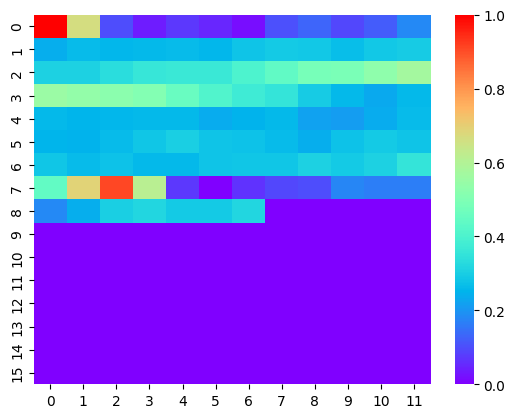

In [41]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [42]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(471, 117)

In [43]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

`mltrainer` provides a ConvBlock, which makes it easier to stack block in the model.
It also provides an architecture inspired by AlexNet (2012) which is used as a starting point for image classification.

Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, or even vision transformers (eg see [torch docs](https://docs.pytorch.org/tutorials/beginner/vt_tutorial.html#classifying-images-with-deit) ) 
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [44]:
from mltrainer.imagemodels import CNNConfig, CNNblocks

In [45]:
config = CNNConfig(
    matrixshape=shape,
    batchsize=32,
    input_channels=1,
    hidden=32,
    kernel_size=3,
    maxpool=2,
    num_layers=2,
    num_classes=5,
)
model = CNNblocks(config)
model(x).shape

Calculated matrix size: 48
Caluclated flatten size: 1536


torch.Size([32, 5])

In [46]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [47]:
config.__dict__

{'matrixshape': (16, 12),
 'batchsize': 32,
 'input_channels': 1,
 'hidden': 32,
 'kernel_size': 3,
 'maxpool': 2,
 'num_layers': 2,
 'num_classes': 5}

Read [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) about micro and macro F1 scores.


In [48]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [49]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D alexnet without normal class")

<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/2', creation_time=1750236057609, experiment_id='2', last_update_time=1750236057609, lifecycle_stage='active', name='2D alexnet without normal class', tags={}>

In [50]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config.__dict__)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-06-18 09:14:04.295 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart2D/20250618-091404
100%|██████████| 94/94 [00:01<00:00, 51.25it/s]
2025-06-18 09:14:07.210 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.1480 test 0.9472 metric ['0.5761', '0.5761', '0.3411', '0.5761', '0.3803']
100%|██████████| 94/94 [00:01<00:00, 54.88it/s]
2025-06-18 09:14:09.618 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.7763 test 0.5918 metric ['0.7296', '0.7296', '0.5400', '0.7296', '0.6015']
100%|██████████| 94/94 [00:01<00:00, 51.83it/s]
2025-06-18 09:14:12.001 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4914 test 0.5007 metric ['0.7948', '0.7948', '0.6643', '0.7948', '0.7164']
100%|██████████| 94/94 [00:01<00:00, 55.48it/s]
2025-06-18 09:14:14.296 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.3935 test 0.3844 metric ['0.8601', '0.8601', '0.7242', '0.8601', '0.7653']
100%|██████████| 94/94 [00:01<00:00, 54.38it/s]
2025-0

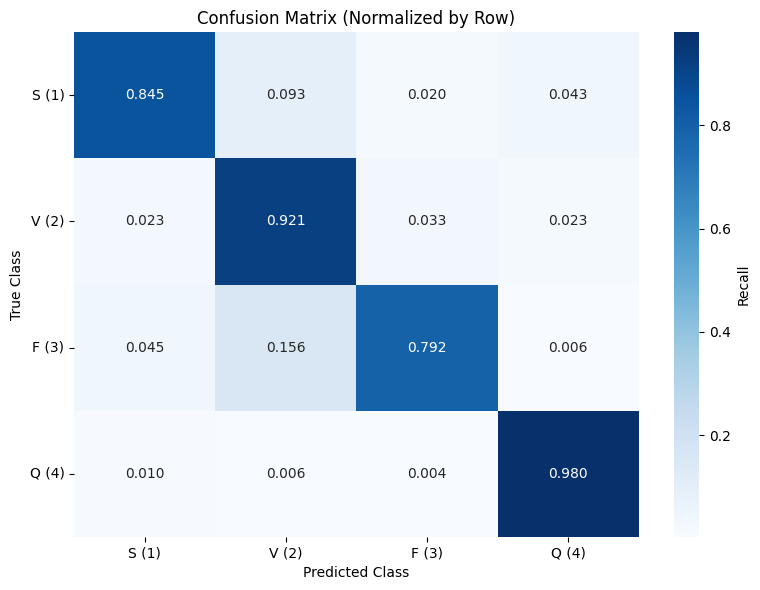

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

# Maak de plot met custom labels
plt.figure(figsize=(8, 6))
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f", cmap='Blues', cbar_kws={'label': 'Recall'})

# Custom tick labels - pas aan op basis van welke classes je hebt
if traindataset.y.min() == 0:  # Als je labels 0-3 hebt (na remapping)
    class_labels = ['S', 'V', 'F', 'Q']
else:  # Als je labels 1-4 hebt (zonder remapping)
    class_labels = ['S (1)', 'V (2)', 'F (3)', 'Q (4)']

plot.set_xticklabels(class_labels, rotation=0)
plot.set_yticklabels(class_labels, rotation=0)
plot.set(xlabel="Predicted Class", ylabel="True Class", title="Confusion Matrix (Normalized by Row)")

plt.tight_layout()
plt.show()